## Titanic passengers survival Classifier

We need to install requirements to the mounted volume in order to have them inside the Kubeflow pipeline

In [28]:
!pip install seaborn pandas scikit-learn evidently --user

#### Import dependencies and load data

In [11]:
import datetime
import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
import os
import glob

from uuid import uuid4
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from IPython.core.display import display, HTML
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import DataDriftTab

In [12]:
TRAIN_DATASET_FRAC = 1.0

In [13]:
path = "/home/jovyan/data/"

PREDICTION_LABEL = 'Survived'

test_df = pd.read_csv(path + "test.csv")
train_df = pd.read_csv(path + "train.csv").sample(frac=float(TRAIN_DATASET_FRAC))

#### Let's explore the data

These are features of the dataset:
```
survival:    Survival 
PassengerId: Unique Id of a passenger. 
pclass:    Ticket class     
sex:    Sex     
Age:    Age in years     
sibsp:    # of siblings / spouses aboard the Titanic     
parch:    # of parents / children aboard the Titanic     
ticket:    Ticket number     
fare:    Passenger fare     
cabin:    Cabin number     
embarked:    Port of Embarkation
```

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 754 to 174
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


In [15]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [16]:
train_df.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
754,755,1,2,"Herman, Mrs. Samuel (Jane Laver)",female,48.0,1,2,220845,65.0000,NaN,S
20,21,0,2,"Fynney, Mr. Joseph J",male,35.0,0,0,239865,26.0000,NaN,S
175,176,0,3,"Klasen, Mr. Klas Albin",male,18.0,1,1,350404,7.8542,NaN,S
16,17,0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,NaN,Q
202,203,0,3,"Johanson, Mr. Jakob Alfred",male,34.0,0,0,3101264,6.4958,NaN,S
131,132,0,3,"Coelho, Mr. Domingos Fernandeo",male,20.0,0,0,SOTON/O.Q. 3101307,7.0500,NaN,S
855,856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S
419,420,0,3,"Van Impe, Miss. Catharina",female,10.0,0,2,345773,24.1500,NaN,S


**Missing data**

Let's see here how much data is missing. We will have to fill the missing features later on.

In [17]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


**Drift Detection**

In [26]:
print(TRAIN_DATASET_FRAC)
train_df_report, train_df_report["target"] = train_df.drop(columns=[PREDICTION_LABEL]), train_df[PREDICTION_LABEL]
data_drift_report = Dashboard(tabs=[DataDriftTab()])
data_drift_report.calculate(train_df_report[:len(train_df_report) // 2], train_df_report[len(train_df_report) // 2:], column_mapping=None)

display(HTML(data_drift_report.html()))

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:5745: RuntimeWarning:

divide by zero encountered in true_divide



**Age and Sex**

/home/jovyan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/jovyan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/jovyan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplo

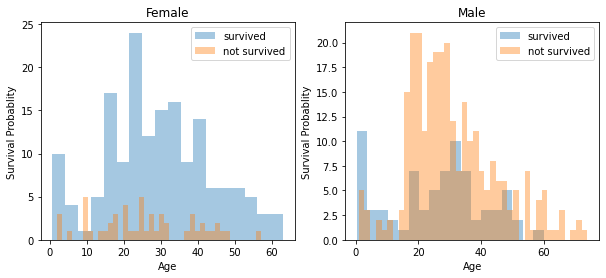

In [8]:
print(TRAIN_DATASET_FRAC)
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax.set_ylabel('Survival Probablity')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
ax.set_title('Male')
_ = ax.set_ylabel('Survival Probablity')

**Pclass**

Explore if `Pclass` is contributing to a person chance of survival 

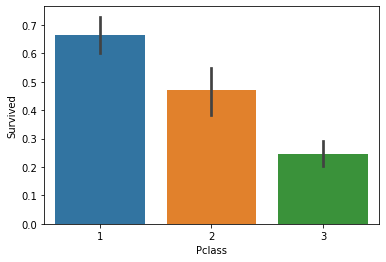

In [10]:
_ = sns.barplot(x='Pclass', y='Survived', data=train_df)

Here we confirm that being in class 1 increases the chances of survival, and that a person in class 3 has high chances of not surviving

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


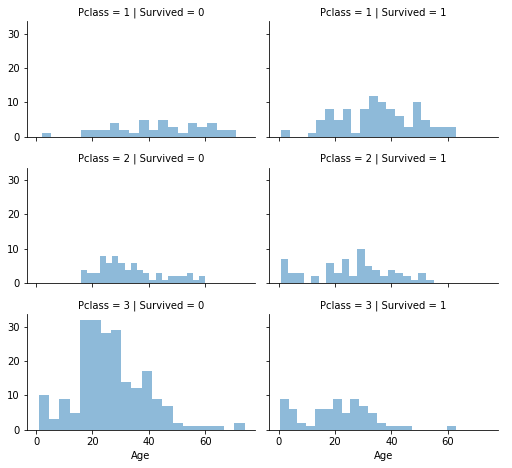

In [11]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

## DATA PROCESSING

#### SibSp and Parch

Combine these two features as the number of relatives

In [12]:
print(TRAIN_DATASET_FRAC)
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
train_df['not_alone'].value_counts()

1    423
0    290
Name: not_alone, dtype: int64

/home/jovyan/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


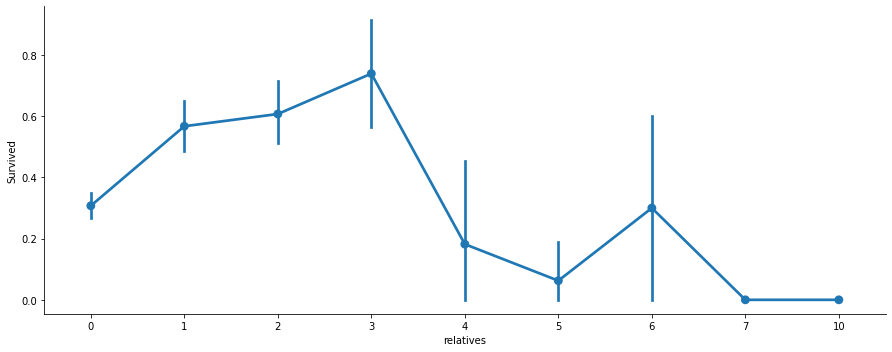

In [13]:
# Survival with respect to the number of relatives in the ship
axes = sns.catplot('relatives','Survived', kind='point',
                      data=train_df, aspect = 2.5, )

In [14]:
# This does not contribute to a person survival probability
train_df = train_df.drop(['PassengerId'], axis=1)
test_df = test_df.drop(['PassengerId'], axis=1)

#### Missing data: Cabin

Create a new `Deck` feature

In [15]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

#### Missing data: Age

Fill missing data from age feature with a random sampling from the distribution of the existing values.

In [16]:
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)
train_df["Age"].isnull().sum()

0

#### Missing data: Embarked

In [17]:
train_df['Embarked'].describe()

count     711
unique      3
top         S
freq      520
Name: Embarked, dtype: object

In [18]:
# fill with most common value
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

#### Convert Features

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 713 entries, 620 to 346
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   713 non-null    int64  
 1   Pclass     713 non-null    int64  
 2   Name       713 non-null    object 
 3   Sex        713 non-null    object 
 4   Age        713 non-null    int64  
 5   SibSp      713 non-null    int64  
 6   Parch      713 non-null    int64  
 7   Ticket     713 non-null    object 
 8   Fare       713 non-null    float64
 9   Embarked   713 non-null    object 
 10  relatives  713 non-null    int64  
 11  not_alone  713 non-null    int64  
 12  Deck       713 non-null    int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 98.0+ KB


In [20]:
print(TRAIN_DATASET_FRAC)
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

#### Titles features

In [21]:
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

#### Sex into numeric

In [22]:
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

#### Drop Ticket feature

In [23]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

#### Embarked into numeric

In [24]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

#### Age into categories

In [25]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

#### Fare into categories

In [26]:
data = [train_df, test_df]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

## New Features

#### Age times Class

In [27]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

#### Fare per person

In [28]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
# Let's take a last look at the training set, before we start training the models.
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title,Age_Class,Fare_Per_Person
620,0,3,0,3,1,0,1,1,1,0,8,1,9,0
635,1,2,1,4,0,0,1,0,0,1,8,2,8,1
884,0,3,0,3,0,0,0,0,0,1,8,1,9,0
469,1,3,1,0,2,1,2,1,3,0,8,2,0,0
120,0,2,0,2,2,0,3,0,2,0,8,1,4,1
259,1,2,1,6,0,1,2,0,1,0,8,3,12,1
504,1,1,1,1,0,0,3,0,0,1,2,2,1,3
542,0,3,1,0,4,2,2,0,6,0,8,2,0,0
300,1,3,1,6,0,0,0,2,0,1,8,2,18,0
669,1,1,1,3,1,0,3,0,1,0,3,3,3,1


## ML

Because the dataset does not provide labels for their testing-set, we need to use the predictions on the training set to compare the algorithms with each other

In [29]:
train_labels = train_df[PREDICTION_LABEL]
train_features = train_df.drop(columns=[PREDICTION_LABEL])

test_labels = test_df[PREDICTION_LABEL]
test_features = test_df.drop(columns=[PREDICTION_LABEL])



#### Random Forest

In [31]:
print(TRAIN_DATASET_FRAC)
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(train_features, train_labels)
acc_random_forest = round(random_forest.score(test_features, test_labels) * 100, 2)

#### Logistic Regression

In [32]:
print(TRAIN_DATASET_FRAC)
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(train_features, train_labels)
acc_log = round(logreg.score(test_features, test_labels) * 100, 2)

#### Gaussian Naive Bayes

In [33]:
print(TRAIN_DATASET_FRAC)
gaussian = GaussianNB()
gaussian.fit(train_features, train_labels)
acc_gaussian = round(gaussian.score(test_features, test_labels) * 100, 2)

#### Linear SVM

In [34]:
print(TRAIN_DATASET_FRAC)
linear_svc = LinearSVC()
linear_svc.fit(train_features, train_labels)
acc_linear_svc = round(linear_svc.score(test_features, test_labels) * 100, 2)

/home/jovyan/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#### Decision Tree

In [35]:
print(TRAIN_DATASET_FRAC)
decision_tree = DecisionTreeClassifier()
decision_tree.fit(train_features, train_labels)
acc_decision_tree = round(decision_tree.score(test_features, test_labels) * 100, 2)

## Results

In [39]:
print(TRAIN_DATASET_FRAC)
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Decision Tree'],
    'Score': [acc_linear_svc, acc_log, 
              acc_random_forest, acc_gaussian, acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
metrics = (acc_linear_svc, acc_log, acc_random_forest, acc_gaussian, acc_decision_tree)

## Clean local cache

In [42]:
print(acc_linear_svc)
print(acc_log)
print(acc_random_forest)
print(acc_gaussian)
print(acc_decision_tree)

81.46
80.34
82.58
75.28
82.02
